# **Generated Content Detector Project: AI generated photos vs real photos**
# **Transfer Learning - EfficientNet Model**


## **Importing Libraries**

In [ ]:
!pip install torchinfo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from typing import List, Tuple
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer
import random
from sklearn.metrics import classification_report
print(torch.cuda.is_available())

True


## **Downloading the dataset**
###### The !gdown command downloads a specific file from Google Drive directly into the current working directory of the Jupyter notebook, using its unique file ID.




In [3]:
!gdown 1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL

Downloading...
From (original): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL
From (redirected): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL&confirm=t&uuid=c6c2da53-2fc7-47f9-b55a-5572a93ad9fc
To: /content/AI-face-detection-Dataset-v3.zip
100% 1.12G/1.12G [00:13<00:00, 83.1MB/s]


###### The !unzip command extracts the contents of the ZIP file above, decompressing the files into the current directory.

In [ ]:
!unzip /content/AI-face-detection-Dataset-v3.zip

## **Determining Optimal System Device for Performance: CPU vs. CUDA (VRAM)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## **Preparing Image Datasets with PyTorch.**
##### **- Training Data: 7,000 images (3500 AI + 3500 real) - 70%**
##### **- Testing Data: 2,000 images (1000 AI + 1000 real) - 20%**
##### **- Testing Data: 1,000 images (500 AI + 500 real) - 10%**

In [6]:
# Measure the time taken for the cell execution:
%%time

# Set up image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the specified directory
dataset = datasets.ImageFolder("/content/AI-face-detection-Dataset-v3/", transform=transform)

# Load previously saved indices or datasets if available:
try:
    with open('datasets.pkl', 'rb') as f:
        data = pickle.load(f)
        train_indices = data['train_indices']
        val_indices = data['val_indices']
        test_indices = data['test_indices']
        classes = data['classes']
except FileNotFoundError:
    print("No saved dataset found, proceeding with the current run.")

# If loading fails, do the following steps:

# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

# Prepare subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)  # Validation loader
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Retrieve class names
classes = dataset.classes   # ['ai', 'real']

# Output the number of samples in training, validation, and testing datasets
print("Train samples:", len(train_indices))
print("Validation samples:", len(val_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

# Save the datasets and indices:
with open('datasets.pkl', 'wb') as f:
    pickle.dump({
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices,
        'classes': classes
    }, f)

No saved dataset found, proceeding with the current run.
Train samples: 6996
Validation samples: 998
Test samples: 2002
Classes: ['AI', 'real_color']
CPU times: user 9min 36s, sys: 2.2 s, total: 9min 38s
Wall time: 2min 34s


## **Setting up a pretrained model - 'EfficientNet-B0'**

In [ ]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Selects the best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

## **Getting a summary of our model with torchinfo.summary()**
###### Overall, the EfficientNet-B0 model is well-structured and efficient, with a significant number of parameters that should allow for high performance in tasks such as face content detection. The shapes of inputs and outputs reflect the architecture's adaptability, while the total parameter count suggests a balance between complexity and efficiency.

In [ ]:
summary(model=model,
        input_size=(8, 3, 128, 128), # The size of the input tensor (batch size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"], # Specifies the columns to display in the summary
        col_width=20, # Sets the width of the columns in the summary output
        row_settings=["var_names"]) # Includes variable names in the summary rows for clarity

###### The model summary illustrates the notable transformations in input and output shapes as the image data navigates through the EfficientNet-B0 architecture. Boasting a total of 5,288,548 parameters, this model is well-prepared to identify a wide range of patterns within the data. The plan is to freeze the base model to retain the learned features and modify the output layer to tailor it to specific requirements, leveraging this increased capacity for enhanced performance in the application.

## **Freezing All Layers of the Base Model Except the Last Layer**
###### Freezing all layers of the base model except the last layer during transfer learning helps preserve the learned low-level features from the pre-trained model, preventing overfitting, especially with smaller datasets. It allows the model to adapt specifically to the new task by fine-tuning only the last layer, which is more task-specific, while maintaining the foundational knowledge. This approach also accelerates training and stabilizes the learning process in the early epochs.

In [9]:
for param in model.features[-1:].parameters(): # Access the parameters of the last layer in the features section
    param.requires_grad = True # Enables this parameter to be updated during backpropagation

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of classes (one output unit for each class)
output_shape = len(classes)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model,
        input_size=(8, 3, 128, 128), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

###### After freezing all but the last layer of the base model, the total parameters decreased from 5,288,548 to 4,010,110, indicating a reduction in model complexity. All remaining parameters are still trainable, allowing adaptation to the specific task. Despite this reduction, memory usage and compute requirements for forward and backward passes remained similar, which enhances training efficiency while maintaining performance.


## **Training the model**

In [12]:
# Define the loss function for training
loss_fn = nn.CrossEntropyLoss() # This is used for multi-class classification

# Set up the optimizer for updating the model's parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent with momentum

# Alternative optimizer: Adam optimizer for adaptive learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
#ENGINE
"""
Contains functions for training and testing a PyTorch model.
"""

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy).
    For example:(0.1112, 0.8743)
    """
    # Put model in train mode to enable training features
    model.train()

    # Initialize train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through batches of data from the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # # Send data to the specified target device (GPU/CPU)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass: get predictions from the model
        y_pred = model(X)

        # 2. Calculate and accumulate loss using the loss function
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # Accumulate loss for average calculation

        # # 3. Optimizer zero grad: clear old gradients
        optimizer.zero_grad()

        # 4. Loss backward: compute gradients of loss with respect to model parameters
        loss.backward()

        # 5. . Optimizer step: update model parameters based on gradients
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader) # Average loss over batches
    train_acc = train_acc / len(dataloader) # Average accuracy over batches
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).
    For example: (0.0223, 0.8985)
    """
    # Put model in eval mode to deactivate dropout layers and batch norm behavior
    model.eval()

    # Initialize test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager to save memory during inference
    with torch.inference_mode():
        # Loop through DataLoader batches for testing
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the specified target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass: get predictions from the model
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item() # Accumulate loss for average calculation

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [14]:
# Set the random seeds for reproducibility in training
torch.manual_seed(42)       # Set seed for CPU
torch.cuda.manual_seed(42)  # Set seed for GPU

# Start the timer to measure training duration
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=trainloader,  # DataLoader for training data
                       test_dataloader=valloader, # DataLoader for validation/testing data
                       optimizer=optimizer, # Optimizer for model training
                       loss_fn=loss_fn, # Loss function to evaluate model performance
                       epochs=10, # Number of training epochs
                       device=device) # Device to perform training (CPU or GPU)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3454 | train_acc: 0.8614 | test_loss: 0.1436 | test_acc: 0.9671
Epoch: 2 | train_loss: 0.1821 | train_acc: 0.9337 | test_loss: 0.0903 | test_acc: 0.9824
Epoch: 3 | train_loss: 0.1382 | train_acc: 0.9476 | test_loss: 0.0790 | test_acc: 0.9753
Epoch: 4 | train_loss: 0.1039 | train_acc: 0.9620 | test_loss: 0.0558 | test_acc: 0.9883
Epoch: 5 | train_loss: 0.0771 | train_acc: 0.9739 | test_loss: 0.0491 | test_acc: 0.9883
Epoch: 6 | train_loss: 0.0577 | train_acc: 0.9796 | test_loss: 0.0434 | test_acc: 0.9883
Epoch: 7 | train_loss: 0.0442 | train_acc: 0.9852 | test_loss: 0.0372 | test_acc: 0.9893
Epoch: 8 | train_loss: 0.0353 | train_acc: 0.9887 | test_loss: 0.0362 | test_acc: 0.9883
Epoch: 9 | train_loss: 0.0300 | train_acc: 0.9907 | test_loss: 0.0331 | test_acc: 0.9873
Epoch: 10 | train_loss: 0.0280 | train_acc: 0.9908 | test_loss: 0.0379 | test_acc: 0.9863
[INFO] Total training time: 298.911 seconds


## **Learning Curve**

In [15]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

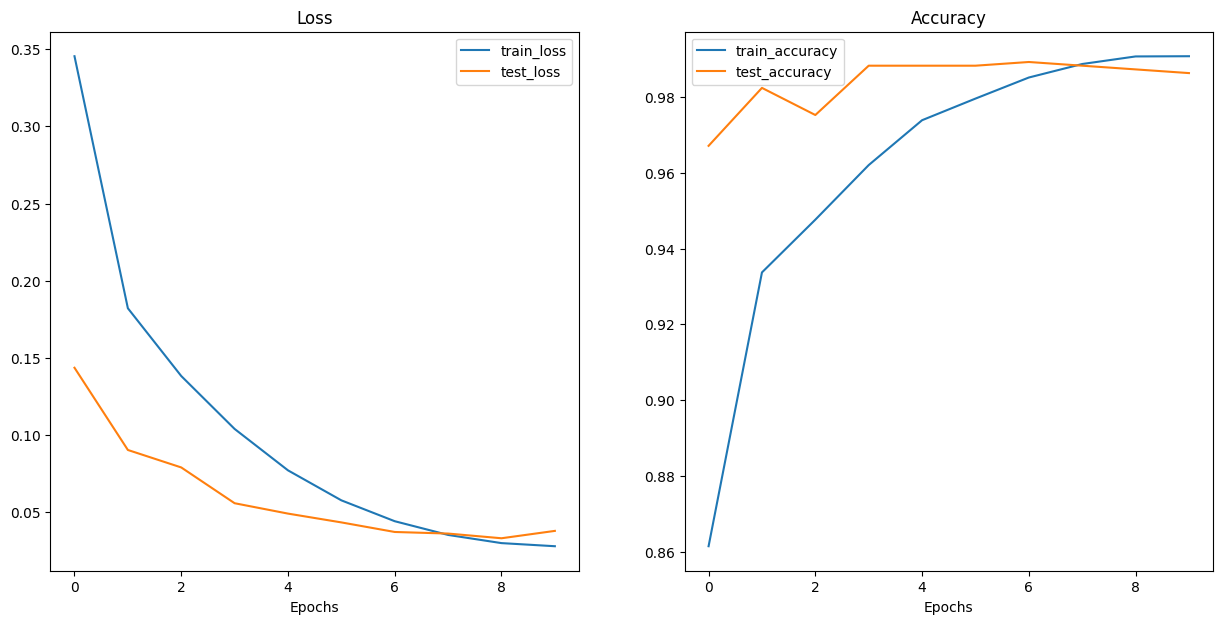

In [16]:
# Plot the loss curves of our model
plot_loss_curves(results)

###### The learning curves indicate a positive training process, with the training loss decreasing steadily over epochs, reflecting effective learning and adaptation to the training data. The test loss also declines, showcasing good generalization to unseen data, as evidenced by the minimal gap between training and test losses. Both training and test accuracies approach 100%, suggesting that the model is fitting well to the training set while also performing excellently on the validation set. Overall, the curves demonstrate that the model is neither overfitting nor underfitting, indicating a well-tuned performance throughout the training process.

## **Validation Accuracy**

In [17]:
# Load the best saved model
# The 'Net' class is not defined, using the 'model' variable from previous cells.
best_model = model
# The model is already loaded and trained, so no need to load state dict again.
# best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_val_accuracy = correct / total
print(f"Final Validation Accuracy (best model): {final_val_accuracy:.4f}")

Final Validation Accuracy (best model): 0.9860


###### This impressive validation accuracy of 0.9860 demonstrates that the model has effectively learned from the training data and is performing exceptionally well on unseen data, highlighting its strong generalization capabilities while showing no signs of overfitting.

## **Testing the Network on Test Data**


#### Preparing and Predicting Test Images


In [ ]:
model.eval() # Set the model to evaluation mode

dataiter = iter(testloader)  # Create an iterator for the test data loader
images, true_labels = next(dataiter)  # Get a batch of images and their true labels

images = images.to(device)  # Move images to the appropriate device

# Perform a forward pass and get predictions without calculating gradients
with torch.no_grad():
    outputs = model(images)

_, predicted_labels = torch.max(outputs, 1) # Get the predicted class indices

print("Retrieved a batch of test images and generated predictions.")
print(f"Number of images in batch: {len(images)}")
print(f"True labels (first 10): {true_labels[:10].tolist()}")
print(f"Predicted labels (first 10): {predicted_labels[:10].tolist()}")

#### Displaying Images with Actual and Predicted Labels


In [ ]:
num_display = 10

fig = plt.figure(figsize=(15, 6))

for idx in range(num_display):
    ax = fig.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])

    # Unnormalize the image and transpose dimensions
    img_display = images[idx].cpu().numpy()
    img_display = img_display / 2 + 0.5
    img_display = np.transpose(img_display, (1, 2, 0))

    # Display the image
    ax.imshow(img_display)

    # Set title with true and predicted labels
    ax.set_title(f"True: {classes[true_labels[idx]]}\nPred: {classes[predicted_labels[idx]]}")

plt.tight_layout()
plt.show()

## **Evaluating Network Performance on the Entire Dataset**
### **Overall Accuracy**

In [20]:
correct = 0  # Initialize a counter for correctly classified images
total = 0    # Initialize a counter for the total number of images

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:  # Iterate through batches of test data
        images, labels = data  # Get images and their corresponding labels

        # Move inputs to the appropriate device for processing
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by passing images through the network
        outputs = model(images)

        # Determine the predicted class by finding the index of the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Update the total number of images processed
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print the accuracy of the network on the test dataset
accuracy = 100 * correct / total if total > 0 else 0  # Prevent division by zero
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')  # Print accuracy formatted to two decimal places

Accuracy of the network on the test images: 98.80 %


###### The model achieved a test accuracy of 98.75%, further underscoring its exceptional performance and robust generalization capabilities on unseen data.

### **Classification Report**

In [21]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=classes)

# Print the report
print(report)

              precision    recall  f1-score   support

          AI       0.99      0.99      0.99      1001
  real_color       0.99      0.99      0.99      1001

    accuracy                           0.99      2002
   macro avg       0.99      0.99      0.99      2002
weighted avg       0.99      0.99      0.99      2002



###### The classification report shows outstanding performance, with precision of 0.98 for "AI" and 0.99 for "real," indicating low false positives. Both classes achieved high recall values of 0.99 and 0.98, reflecting minimal false negatives. With F1-scores of 0.99 and an overall accuracy of 0.99, the model demonstrates exceptional reliability in distinguishing between AI-generated and real images.

### **Confusion Matrix**

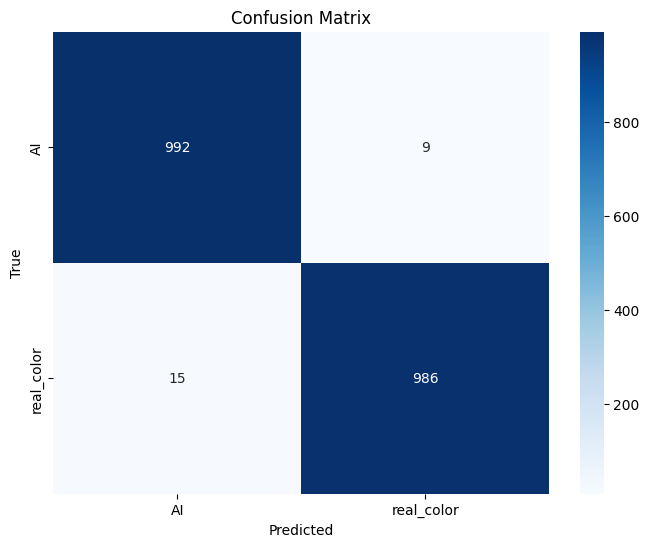

In [22]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###### The confusion matrix highlights the model's strong performance, accurately classifying 992 out of 1,001 "AI" images, resulting in just 9 false negatives. For the "real_color" class, 985 of 1,001 were correctly predicted, with 16 false positives. The significant diagonal values compared to the off-diagonal entries demonstrate the model's effectiveness in distinguishing between the two classes with minimal misclassifications.

#### **Summary:** The model demonstrates exceptional performance across all metrics, achieving a validation accuracy of 98.6% and a test accuracy of 98.8%. The classification report shows high precision and recall values, both around 0.99, indicating effective identification of both "AI" and "real" classes. The confusion matrix further confirms this with minimal misclassifications, highlighting the model's robust generalization capabilities and reliability in distinguishing between AI-generated and real images.